First, we set up a function that generates $N$ cities randomly in a $1\times1$ square box and one that calculates the distance between each two of them. The input is the number of cities $N$ and the city coordinates, and the output is city coordinates and an $N\times N$ matrix with its $i,j$ element being the distance between city $i$ and $j$ respectively.

In [2]:
import numpy as np
from numba import njit

@njit
def generate_cities(N):
    # Generate N cities randomly in a 1x1 square box
    cities_coordinates = np.random.rand(N, 2)  # Each city is represented by its (x, y) coordinates
    return cities_coordinates

@njit
def calculate_distances(cities_coordinates, N):
    distances = np.zeros((N, N))  # Initialize an N x N matrix for distances
    
    for i in range(N):
        for j in range(N):
            distances[i][j] = np.sqrt(np.sum((cities_coordinates[i] - cities_coordinates[j]) ** 2))  # Calculate Euclidean distance
    
    return distances

The next function generates an initial guess for the traveling salesman's shortest route. Starting from city $i$, find its nearest neighbour $j$; then keep finding the next nearest neighbour until each of the $N$ cities has appeared once. This function takes the distance matrix, the city number, and a starting index as input and gives an $N$-element sequence recording the route as output.

In [4]:
def generate_initial_route(distances, N, i):
    initial_route = [i]  # Start from city 0
    visited = set([i])  # Keep track of visited cities
    
    while len(initial_route) < N:
        # Find the nearest neighbour of the last city in the route that hasn't been visited yet
        min_dist = float('inf')  # Initialize to a large value
        next_city = -1  # Index of the next city to add to the route
        for j in range(N):
            if j not in visited:  # Ignore already visited cities
                dist = distances[initial_route[-1]][j]  # Distance from the last city in the route to city j
                if dist < min_dist:  # Update the minimum distance and next city
                    min_dist = dist
                    next_city = j
        initial_route.append(next_city)  # Add the next city to the route
        visited.add(next_city)  # Mark the city as visited

    # Find the starting point
    index = initial_route.index(0)
    initial_route = initial_route[index:] + initial_route[:index]
    
    return initial_route  # The initial route as a sequence of city indices

The minimal change of a route is a swap between two city routes (route[$(i-1)$%$N$],route[$i$]) and (route[$j$],route[$(j+1)$%$N$]), $i < j < N$, which trades the original city routes for (route[$(i-1)$%$N$],route[$j$]) and (route[$i$],route[$(j+1)$%$N$]), which is to reverse the city sequence from route[$i$] to route[$j$]. The swap makes sense only when the length of the reversed sequence is no longer than $N-1$, i.e. $j - i + 1 <= N - 1$ or $j - i < N - 2$. Now let's define the swap function with their input being a route and the swap indices $i$ and $j$ and their output being the swapped route or the unswapped route of illegal swap indices $i$ and $j$.

In [6]:
def swap_route_segment(route, N, i, j):
    # Check if the swap is within bounds and makes sense
    if i < j and j - i < N - 2:  # Condition for valid swap
        # Perform the swap by reversing the sequence from route[i] to route[j]
        route[i:j+1] = reversed(route[i:j+1])  # Swap the segment
        return route  # Return the swapped route
    else:
        return route

Now we want a function that decides whether or not to swap. Define the energy $E$ as the length difference between the swapped and unswapped route, i.e. $E$ = distances[route[$(i-1)$%$N$]][route[$j$]] + distances[route[$i$]][route[$(j+1)$%$N$]] - distances[route[$(i-1)$%$N$]][route[$i$]] - distances[route[$j$]][route[$(j+1)$%$N$]]. If $E < 0$, we always want to do the swap, and the function should return True. If $E > 0$, we swap with a $e^{-E/T}$ probability, where $T$ is a temperature from the input. This function takes the distances matrix, the route, the city number, the swap indices $i$ and $j$, and the temperature $T$ as input, and returns True or False, i.e. whether or not to swap.

In [8]:
@njit
def should_swap(distances, route, N, i, j, T):
    if i < j and j - i < N - 2:  # Condition for valid swap
        # Calculate the energy difference between the swapped and unswapped route
        E = distances[route[(i - 1) % N]][route[j]] + distances[route[i]][route[(j + 1) % N]] - distances[route[(i - 1) % N]][route[i]] - distances[route[j]][route[(j + 1) % N]]
        
        # If E is negative, always accept the swap
        if E < 0:
            return True
        
        # If E is positive, accept the swap with probability e^{-E/T}
        if np.exp(- E / T) > np.random.rand():  # Using NumPy's random number generator for speed and efficiency
            return True
        else:
            return False
    else:
        return False

Now we define a function that calculates the standard deviation of all the city routes and then sets the initial temperature based on that. Use the distance matrix and city number as input, and return the initial temperature. Notice that the matrix diagonal is not wanted when calculating the standard deviation.

In [10]:
@njit
def calculate_initial_temperature(distances, N):
    # Calculate the mean value of squared distances
    squared_distances = np.square(distances)
    sum_squared_distances = np.sum(squared_distances)
    mean_squared_distances = sum_squared_distances / (N * (N - 1))
    
    # Calculate the mean value of distances
    sum_distances = np.sum(distances)
    mean_distances = sum_distances / (N * (N - 1))
    
    # Calculate the standard deviation of all city routes
    std_dev = np.sqrt(mean_squared_distances - mean_distances ** 2)
    
    # Set the initial temperature
    initial_temperature = 0.2 * std_dev
    
    return initial_temperature

With $N$ being the number of cities, there are also $N$ city routes in any given route, and therefore $N (N - 1) / 2$ possible ways of swap. For the cooling-down strategy, we reduce the temperature by 0.8% initial_temperature every $N (N - 1)$ step, which measures the time elapsed. Here comes the temperature function that takes initial_temperature, current step number, and city number, and returns the current temperature.

In [12]:
@njit
def current_temperature(initial_temperature, step, N):
    # Calculate twice the number of possible swaps (N*(N-1)/2)
    twice_num_swaps = N * (N - 1)
    
    # Determine the current step's temperature decrement
    temperature_decrement = 0.008 * initial_temperature  # Decrease by 0.8% of initial temperature
    
    # Calculate the current temperature based on the step number and decrement
    current_temperature = initial_temperature - (step // twice_num_swaps) * temperature_decrement
    
    # Ensure the temperature doesn't fall below a minimum threshold (e.g., a small positive value)
    current_temperature = max(current_temperature, 0.01 * temperature_decrement)  # Adjust this minimum threshold as needed
    
    return current_temperature

Here is a function that calculates the route length given the distances matrix and the route.

In [14]:
@njit
def calculate_route_length(distances, route, N):
    route_length = 0  # Initialize the length of the route to zero
    for i in range(N):
        # Calculate the distance between the current city and the next one in the route
        city_i = route[i]
        city_j = route[(i + 1) % N]  # Use modulo to loop back to the start if necessary
        route_length += distances[city_i][city_j]  # Add the distance to the total route length
    return route_length

Now comes the function that searches for the shortest route. Given the distances matrix, city number, initial temperature, current route, and current step number, the search function goes through every possible swap $i,j$, checks by should_swap(), and records the step number. If False, do nothing except add 1 to the step number; if True, do the swap $i,j$, rotate the route to the left by $i$ to make city route[$i$] the first element in the route, add 1 to the step and then return with the swapped route, current step number and a True. If all possible swaps are checked with none triggered, return with the current route, step number, and a False.

In [16]:
def search_for_shortest_route(distances, N, initial_temperature, route, step):    
    process = False # Flag to indicate if any swaps were processed during this iteration
    
    # Check all possible swaps twice
    for k in range(2):
        for i in range(N):
            for j in range(i + 1, N):  # Only check swaps with a different city index to avoid duplicates
                T = current_temperature(initial_temperature, step, N) # Calculate the temperature
                if should_swap(distances, route, N, i, j, T):  # Call your custom function to determine if a swap should be made
                    route = swap_route_segment(route, N, i, j) # Make the swap
                    route = route[i:] + route[:i] # Do the rotation
                    step = step + 1 # Record the step
                    process = True # Swap processed
                    
                    return route, step, process
                else:
                    step = step + 1 # Record the step
                    
    return route, step, process

Now we basically have everything necessary on board, we build up the main function that finds the shortest route.

In [18]:
def find_shortest_route(distances, N, initial_route):
    route = initial_route # Initial guess of the route
    initial_temperature = calculate_initial_temperature(distances, N) # Calculate the initial temperature
    
    # Initialization of temporary variables
    step = 0
    process = True

    # Start the loop
    while process:
        route, step, process = search_for_shortest_route(distances, N, initial_temperature, route, step)

    # Find the starting point
    index = route.index(0)
    route = route[index:] + route[:index]

    # Calculate the length
    route_length = calculate_route_length(distances, route, N)

    return route, route_length, step

Let's give it a shot.

In [20]:
N = 5
cities_coordinates = generate_cities(N)
distances = calculate_distances(cities_coordinates, N)
initial_route = generate_initial_route(distances, N, 0)
route, route_length, step = find_shortest_route(distances, N, initial_route)
print(route)
print(route_length)
print(step)

[0, 2, 4, 1, 3]
2.6526023237054903
48


Next, we want to check the answer by enumeration.

In [22]:
import itertools

def find_shortest_route_by_enumeration(distances, N):
    # Set the starting city
    start_city = 0
    
    # Generate all permutations of the remaining cities (1 to N-1)
    remaining_cities = list(range(1, N))
    shortest_route = None
    shortest_length = float('inf')
    
    # Iterate through all possible routes starting from city 0
    for perm in itertools.permutations(remaining_cities):
        route = [start_city] + list(perm)  # Route starts at city 0 and follows the permutation
        
        # Calculate the total distance of the current route
        route_length = calculate_route_length(distances, route, N)
        
        # Check if this is the shortest distance found
        if route_length < shortest_length:
            shortest_length = route_length
            shortest_route = route
    
    return shortest_route, shortest_length

In [23]:
N = 5
cities_coordinates = generate_cities(N)
distances = calculate_distances(cities_coordinates, N)
initial_route = generate_initial_route(distances, N, 0)
route, route_length, step = find_shortest_route(distances, N, initial_route)
route_by_enumeration, length_by_enumeration = find_shortest_route_by_enumeration(distances, N)
print('step =', step)
print('route =',route)
print('route_by_enumeration =',route_by_enumeration) 
print('route_length / length_by_enumeration =',route_length / length_by_enumeration)

step = 70
route = [0, 1, 4, 3, 2]
route_by_enumeration = [0, 1, 4, 3, 2]
route_length / length_by_enumeration = 1.0


Now plot the route.

In [25]:
import matplotlib.pyplot as plt

def plot_route(route, cities_coordinates):
    # Extract coordinates for cities in the route
    route_coordinates = np.array([cities_coordinates[city] for city in route])
    
    # Create the plot
    plt.figure(figsize=(6, 6))  # Set the figure size to visualize the square region
    plt.axis("equal")  # Equal aspect ratio
    plt.xlim(0, 1)  # Set the limits of the x-axis to match the square region
    plt.ylim(0, 1)  # Set the limits of the y-axis to match the square region
    plt.plot(route_coordinates[:, 0], route_coordinates[:, 1], linestyle='-', color='black')
    plt.scatter(route_coordinates[1:, 0], route_coordinates[1:, 1], color='black')
    plt.scatter(route_coordinates[0, 0], route_coordinates[0, 1], s=100, color='red')
    
    # Annotate the cities
    plt.annotate(f'{route[0]}', route_coordinates[0], textcoords="offset points", color='red', xytext=(10,0), ha='center')
    for i, (x, y) in enumerate(route_coordinates[1:]):
        plt.annotate(f'{route[i + 1]}', (x, y), textcoords="offset points", color='black', xytext=(10,0), ha='center')
    
    # Close the route
    plt.plot([route_coordinates[-1, 0], route_coordinates[0, 0]], 
             [route_coordinates[-1, 1], route_coordinates[0, 1]], color='black', linestyle='-')

    plt.title(f'Shortest Route Between {N} Cities')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

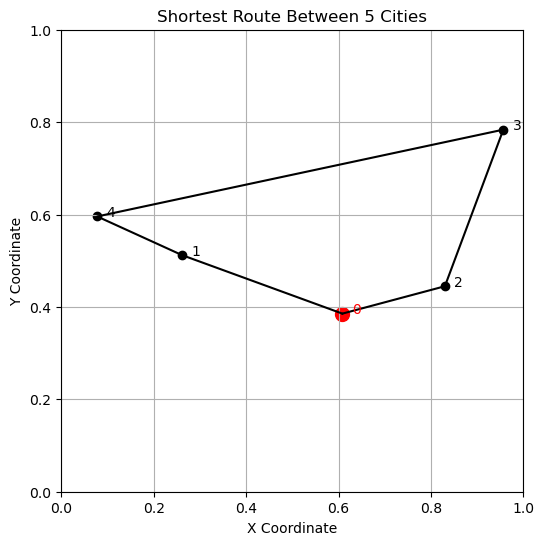

In [26]:
plot_route(route, cities_coordinates)

Now a function that tries different initial guesses is wanted. For $N$ cities, there are $N$ choices of starting points in generating the initial route. We want to go through all of them and see whether or not they lead to the same shortest path. If they result in different answers, we assume the shortest one to be the true answer, or the global minimum, and calculate the accuracy rate. The function takes only the distance matrix and $N$ as input and returns the shortest route, shortest length, and accuracy rate.

In [28]:
def try_all_initial_guesses(distances, N):
    shortest_route = [] # Nothing yet
    shortest_length = float('inf') # Set to a large value
    accuracy_count = 0 # Set count to zero
    
    for i in range(N):
        initial_route = generate_initial_route(distances, N, i)
        route, route_length, step = find_shortest_route(distances, N, initial_route)
        if abs(route_length / shortest_length - 1) < 1e-15: # Difference within the machine precision
            accuracy_count += 1
        elif route_length < shortest_length: # Find a shorter route
            shortest_route = route[:]
            shortest_length = route_length
            accuracy_count = 1 # reset the count
        else: # Fail to find the shortest route
            pass # Do nothing
    
    accuracy_rate = accuracy_count / N
    return shortest_route, shortest_length, accuracy_rate

shortest route = [0, 1, 4, 3, 2]
shortest length = 2.061599407209326
accuracy rate = 1.0


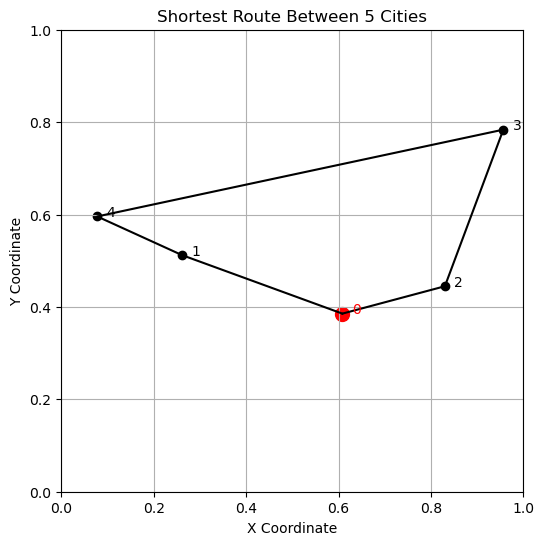

In [29]:
shortest_route, shortest_length, accuracy_rate = try_all_initial_guesses(distances, N)
print('shortest route =', shortest_route)
print('shortest length =', shortest_length)
print('accuracy rate =', accuracy_rate)
plot_route(shortest_route, cities_coordinates)

Finally, we introduce a function that tries out different $N$ to find out the trend of accuracy rate and route length. It takes a list of $N$ and the number of different initial conditions as input and returns a list of accuracy rates and shortest lengths averaged over different initial conditions.

In [31]:
def trend_of_accuracy_and_length(N_list, number_of_init):
    # Initialization
    acc_rate_list = []
    shortest_len_list = []
    
    for N in N_list:
        times = round(number_of_init / N) # How many times to run try_all_initial_guesses()
        acc_rate_sum = 0
        shortest_len_sum = 0
        
        for i in range(times):
            cities_coordinates = generate_cities(N)
            distances = calculate_distances(cities_coordinates, N)
            shortest_route, shortest_length, accuracy_rate = try_all_initial_guesses(distances, N)
            acc_rate_sum += accuracy_rate
            shortest_len_sum += shortest_length
        
        # Averaged results
        acc_rate_average = acc_rate_sum / times
        shortest_len_average = shortest_len_sum / times

        acc_rate_list.append(acc_rate_average)
        shortest_len_list.append(shortest_len_average)

    return acc_rate_list, shortest_len_list

In [ ]:
N_list = [5, 25, 50, 100]
number_of_init = 100
acc_rate_list, shortest_len_list = trend_of_accuracy_and_length(N_list, number_of_init)
print('acc_rate_list =', acc_rate_list)
print('shortest_len_list =', shortest_len_list)